In [1]:
from datetime import date, timedelta
import folium
from pathlib import Path
import sentinel_helpers

Before running this notebook the files have to be downloaded. See [01a Download from Scihub.ipynb](01a Download from Scihub.ipynb) for further information.

In [2]:
product_path = Path('input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip')
index_to_calculate = 'nbr'

## Preview of product

In [3]:
#from sentinel_helpers import scihub_band_paths
#import rasterio.plot as rplot
#
#tci = scihub_band_paths(product_path, 'TCI', '60m')[0]
#with r.open(tci):
#    rplot.show(tci)

## Define Formulas

We define the formulas as data so we can substitute the bands with actual values later on and execute the operations when needed.
We use a lisp-like language with prefix notation for this.

### Operators

The indices are calculated using these four basic arithmetic operations.
We define them using `reduce` so they support variadic arguments:

In [4]:
from functools import reduce

def add(nums):
    return reduce(lambda a, b: a + b, nums)

def sub(nums):
    return reduce(lambda a, b: a - b, nums)

def div(nums):
    return reduce(lambda a, b: a / b, nums)

def mul(nums):
    return reduce(lambda a, b: a * b, nums)

### Indices

Each element in a formula can be either a function, a string or a tuple.
A string represents a band number, a function represents an arithmetic operation and a tuple allows us to express nested formulas.

We first define some spectral indices using these basic elements:

In [5]:
indices = {
    # normalized difference in vegetation
    'ndvi': (div, (sub, 'B08', 'B04'), (add, 'B08', 'B04')),
    # normalized burn ratio
    'nbr': (div, (add, 'B08', 'B12'), (sub, 'B08', 'B12')),
    # bare soil index
    'bsi': (div, (sub, (add, 'B11', 'B04'), (add, 'B08', 'B02')),
                 (add, (add, 'B11', 'B04'), (add, 'B08', 'B02')))
}

… and verify user input:

In [6]:
supported_indices = ', '.join(indices.keys())
assert index_to_calculate in supported_indices, f'Only the following indices are supported: {supported_indices}'

We define a function that returns all of the bands referenced in a formula.
This is necessary when resolving these references to data sets.

In [7]:
def get_bands(formula):
    bands = set()
    for element in formula:
        if type(element) == tuple:
            # recur for subformulas
            for band in get_bands(element):
                bands.add(band)
        elif type(element) == str:
            bands.add(element)
    return bands

The resolving process needs a `band_map` in the form of `band_num` → `numpy.array`:

In [8]:
def evaluate_formula(band_map, formula):
    op = formula[0]
    args = []
    for element in formula[1:]:
        if type(element) == tuple:
            # recur on sub-formula
            args.append(evaluate_formula(band_map, element))
        elif type(element) == str:
            # substitute band number
            args.append(band_map[element])
        else:
            # just append the number
            args.append(element)
    return op(args)

In [9]:
def prefix_to_infix_str(formula):
    '''
    Returns a human-readable string of the above data-based notation. Useful
    for debugging.
    '''
    result = ['(']
    
    # operation
    op = formula[0]
    if op == add:
        sym = ' + '
    elif op == sub:
        sym = ' - '
    elif op == div:
        sym = ' / '
    elif op == mul:
        sym = ' * '
        
    operands = formula[1:]
    for idx, operand in enumerate(operands, start=1):
        if type(operand) == tuple:
            result.append(prefix_to_infix_str(operand))
        else:
            result.append(str(operand))
        if idx < len(operands):
            result.append(sym)
        
    result.append(')')
    return ''.join(result)

#### Small test

In [10]:
formula = (add, *range(5), (mul, *range(1, 4)))

In [11]:
prefix_to_infix_str(formula)

'(0 + 1 + 2 + 3 + 4 + (1 * 2 * 3))'

In [12]:
evaluate_formula({}, formula)

16

## Extraction of relevant band file paths

In [13]:
from pathlib import Path

In [14]:
bands = get_bands(indices[index_to_calculate])
bands = list(bands)
bands

['B12', 'B08']

## Resampling

Some bands are not available in all resolutions.

The band `B08` is available only at 10m and the band `B12` only at 20m:

In [15]:
from sentinel_helpers import scihub_band_paths
band_paths = list(sorted(scihub_band_paths(product_path, bands)))
band_paths

['zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R10m/T33UUU_20190417T102031_B08_10m.jp2',
 'zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R20m/T33UUU_20190417T102031_B12_20m.jp2',
 'zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R60m/T33UUU_20190417T102031_B12_60m.jp2']

We solve this by upsampling the lower bands.
First we discard duplicate bands which are already available in higher resolution:

In [16]:
highest_resolution_band_paths = []
covered_bands = set()
for band in band_paths:
    band_num = band.split('_')[-2]
    if band_num in covered_bands:
        continue
    else:
        highest_resolution_band_paths.append(band)
        covered_bands.add(band_num)
highest_resolution_band_paths

['zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R10m/T33UUU_20190417T102031_B08_10m.jp2',
 'zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R20m/T33UUU_20190417T102031_B12_20m.jp2']

In [17]:
def resolution(band_path):
    return int(band_path.split('_')[-1].split('.')[0].replace('m', ''))

In [18]:
target_resolution = list(sorted(resolution(band) for band in highest_resolution_band_paths))[0]
target_resolution

10

## Generate the raster cloud mask

In order to construct a cloud mask that we can operate on, we need to calculate the transformation needed from real coordinates (vector cloud mask) to one of the highest resolution rasters:

In [19]:
from sentinel_helpers import scihub_cloud_mask
import rasterio as r
from rasterio.features import geometry_mask
import matplotlib.pyplot as pplt

highres_raster_path = [band_path for band_path in highest_resolution_band_paths if resolution(band_path) == target_resolution][0]
highres_raster_path

'zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R10m/T33UUU_20190417T102031_B08_10m.jp2'

In [20]:
with r.open(highres_raster_path) as src:
    target_transform = src.transform
    target_shape = src.shape

target_shape, target_transform

((10980, 10980),
 Affine(10.0, 0.0, 300000.0,
        0.0, -10.0, 5900040.0))

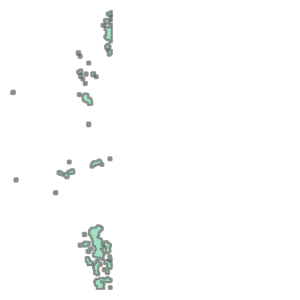

In [21]:
vector_cloud_mask = scihub_cloud_mask(product_path)
vector_cloud_mask

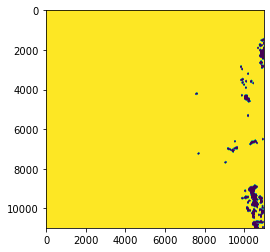

In [25]:
# pixels with clouds are True, pixels without are False
raster_cloud_mask = geometry_mask(vector_cloud_mask,
                                   out_shape=target_shape,
                                   transform=target_transform)

pplt.imshow(raster_cloud_mask)

## Calculate the index

In [23]:
import numpy as np
from numpy.ma import masked_array

from rasterio.enums import Resampling
import rasterio.plot as rplt

from sentinel_helpers import RasterReaderList, scihub_cloud_mask, scihub_normalize_range
from tqdm.notebook import tqdm

from tempfile import NamedTemporaryFile

out_dir = Path('output/spectal_indices/')
out_dir.mkdir(exist_ok=True, parents=True)

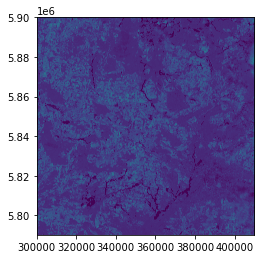

In [34]:
with r.open(highest_resolution_band_paths[0]) as src:
    data = src.read(1)
    rplt.show(src)

In [41]:
(data & raster_cloud_mask).mean()

0.13531366850143164

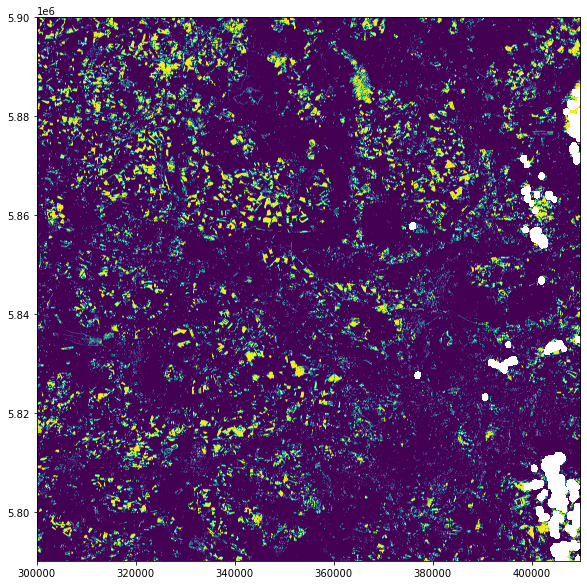

Wrote result to output/spectal_indices/T33UUU_20190417T102031_NBR_10m.tif
CPU times: user 56.8 s, sys: 15.7 s, total: 1min 12s
Wall time: 40.9 s


In [43]:
%%time

with RasterReaderList(highest_resolution_band_paths) as readers:
    # build the band_map as described above and scale up where needed
    band_map = {}
    for reader in tqdm(readers, desc='Resampling datasets'):
        band_num = reader.name.split('_')[-2]
        data_resolution = resolution(reader.name)
        scale_factor = int(data_resolution / target_resolution)
        
        band_map[band_num] = scihub_normalize_range(
            reader.read(out_shape=(
                int(reader.height * scale_factor),
                int(reader.width * scale_factor)
            ), resampling=Resampling.bilinear)
        ).astype('float32')
        
        if scale_factor == 1:
            out_name = Path(reader.name).name.replace(band_num, index_to_calculate.upper())
            out_name = out_name.replace('.jp2', '.tif')
            out_path = out_dir / out_name
            out_meta = reader.meta.copy()
    
    # ignore numpy division errors (i.e. divide by 0) in this context;
    # divide by zero results in `nan`, which we fill with zeros. clouds are
    # masked using the raster_cloud_mask created above
    with np.errstate(divide='ignore', invalid='ignore'):
        index = evaluate_formula(band_map, indices[index_to_calculate])
        np.nan_to_num(index, nan=0.0, copy=False)
        # we need to invert the cloud mask (`~`) because we want to hide those pixels that are cloudy
        index = masked_array(index, mask=~raster_cloud_mask)
    
    out_meta.update({
        'count': 1,
        'driver': 'GTiff',
        'dtype': 'float32'
    })
    
    with r.open(out_path, 'w+', **out_meta) as dst:
        dst.write(index)
        
        pplt.figure(figsize=(10, 10))
        rplt.show(index, transform=out_meta['transform'])

        print(f'Wrote result to {out_path}')